#  ML Final Project - Predicting fat level in Canadian cheese
## Jesse Sallis -Bcom, MIB
### March 2022

Introduction: Purpose of notebook is to explore a Canadian cheese dataset and build/test multiple machine learning models to predict fat level of various cheeses. Analysis will consist of importing/cleaning dataset, developing baseline model, testing multple machine learning models and tuning hyperparameters to create the most accurate model possible.


### Question that will be explored:
* Can Canadian cheese be accurately classified either low-fat or high-fat based on qualitative and quantative features?
* If so, what feature is most effective at doing so?

This is a classification question where each unique cheese will be classified as either lower or higher fat. The purpose of predicting fat levels is health driven; perhaps due to food allergies or diet restrictions we want to avoid cheese with high fat levels. Given this, our positive label will be lower fat. Looking over the data, I expect we will be able to develop a proficient model based on trends that are an effective predicter of fat content. For example, cheese made from goat milk with a low moisture content tends to have a certain fat level - if strong relationships like this exist within the dataset then our model will identify this and help drive predictive results.

                
### Datasets

For the purpose of this excerise, 1 datasets will be used. Data can be found here https://data.amerigeoss.org/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b and follows a https://open.canada.ca/en/open-government-licence-canada license.
                
* **cheese_data.csv**
    * collection of various Canadian cheese with qualitative and quantative descriptors (milk type, moisture content and manufactor location)

### Method and Results

*Using the above dataset, analysis process will flow like:*
* Load in dataset as dataframe
* Split train/test splits, Run initial diagnoisis on data quality (NaNs, missing values, incorect dtypes)
* Determine appropiate columns feature and what scaling/imputation steps are needed
* Create Dummy model for comparisons
* Create pipeline and use hyper pararmeter tuning on model to determine best scoring model
* Demonstrate prediction scores of best scoring model

In [1]:
#importing required packages, additional packages will be imported as needed
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate

#to clean up the workflow
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

#importing dataset
cheese_df = pd.read_csv('data/cheese_data.csv')
cheese_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [2]:
#splitting train/test
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=32,shuffle=True, stratify=None)
train_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
443,1467,QC,Artisan,54.0,Smoked salmon,Smooth rind covered with dill,0,Soft Cheese,Cow,Pasteurized,Bloomy Rind,SOMO Brie au saumon fumé,lower fat
748,1843,MB,Farmstead,42.0,Inferno finish,NaN,0,Firm Cheese,Cow,Pasteurized,No Rind,Red Hot Chili Pepper Jack,lower fat
982,2308,QC,Industrial,34.0,"It exudes rich nutty, buttery touches, and its...",It is a hard cheese with a orangy washed rind,0,Firm Cheese,Cow,Pasteurized,Washed Rind,Pacific Rock,higher fat
218,1224,QC,Artisan,45.0,Salty,Twisted cheese,0,Firm Cheese,Cow,Pasteurized,No Rind,Darac,lower fat
537,1566,QC,Artisan,45.0,NaN,Creamy,0,Semi-soft Cheese,Ewe and Cow,Thermised,NaN,Duo du Paradis,lower fat


## Exploring our dataset
 
After splitting test/train, we can now look at our dataset's characateristics. Features are a combination of quantatative (moisture percent) and quantative (CheeseName) descriptors. Our target will be the column *FatLevel* with balanced classes of low/high fat.

The majority of the columns are of dtype object, modification (ex: one-hot encoding, bag of words) will need to be applied for columns to be useful within our model. CheeseId being an identification feature, can be dropped. 3 columns have significant NaNs (FlavourEn,CharacteristicsEn,RindTypeEn), all object dtypes; easiest solution would be to drop these columns however that could mean depriving the model of potentially useful features. Simpleimputator with strategy='most_frequenet' will work for these and mean values for int columns will work. RindType, given only 4 unique values and such high number of NaN's can be dropped. Organic column is current in binary form - this is helpful as it's already transformed.

In [3]:
print(train_df.info())
train_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 443 to 727
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       823 non-null    float64
 4   FlavourEn             646 non-null    object 
 5   CharacteristicsEn     524 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        817 non-null    object 
 8   MilkTypeEn            833 non-null    object 
 9   MilkTreatmentTypeEn   787 non-null    object 
 10  RindTypeEn            582 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB
None


,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
count,833.000000,833,833,823.000000,646,524,833.000000,817,833,787,582,833,833
unique,NaN,9,3,NaN,509,446,NaN,6,8,3,4,831,2
top,NaN,QC,Industrial,NaN,Mild,Creamy,NaN,Firm Cheese,Cow,Pasteurized,No Rind,Boerenkaas,lower fat
freq,NaN,651,369,NaN,52,14,NaN,285,588,656,321,2,556
mean,1567.753902,NaN,NaN,47.317011,NaN,NaN,0.086435,NaN,NaN,NaN,NaN,NaN,NaN
std,442.795353,NaN,NaN,9.324914,NaN,NaN,0.281174,NaN,NaN,NaN,NaN,NaN,NaN
min,228.000000,NaN,NaN,17.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1296.000000,NaN,NaN,40.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1552.000000,NaN,NaN,46.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1905.000000,NaN,NaN,52.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#classes are balanced so no additional transformations needed, no need to use stratify parameter for train_test_split
train_df['FatLevel'].value_counts()/train_df['FatLevel'].count()

lower fat     0.667467
higher fat    0.332533
Name: FatLevel, dtype: float64

In [5]:
import altair as alt

In [6]:
#historgam
base = alt.Chart(train_df)

bar = base.mark_bar(opacity=0.4,
    binSpacing=0).encode(
    alt.X('MoisturePercent:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()',stack=None), alt.Color('FatLevel:N',scale=alt.Scale(scheme='dark2'))
).properties(title='Figure 1 - Breakdown of Moisture Percent by Fat Level', width=600,
    height=300)

bar 

alt.Chart(...)

In [7]:
#stack bar chart 
alt.Chart(train_df).mark_bar().encode(alt.X('ManufacturerProvCode:N'),
    alt.Y('count()'),alt.Color('FatLevel:N',scale=alt.Scale(scheme='dark2'))
).properties(title="Figure 2 - Source Province by Fat Level", width=400,
    height=400)

alt.Chart(...)

Two major takeaways from the above charts; Lower fat cheeses tend to have a higher moisture level and the majority of the cheeses are manufactored in Quebec.

In [8]:
#splitting in X/Y
X_train = train_df.drop(columns='FatLevel')
y_train = train_df['FatLevel']
X_test = test_df.drop(columns='FatLevel')
y_test = test_df['FatLevel']

In [9]:
from sklearn.dummy import DummyClassifier

#let's create a Dummy Model to be used as baseline with FatLevel as target, Module 1: Baselines: Dummy Regression

dummy = DummyClassifier(strategy='most_frequent',random_state=55)
dummy.fit(X_train,y_train)
print(dummy.score(X_test,y_test).round(3))
print("Makes sense, split between low/high fat is ~ 2/3 low fat, consistent with what we saw in train_df")

0.612
Makes sense, split between low/high fat is ~ 2/3 low fat, consistent with what we saw in train_df


In [10]:
train_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
443,1467,QC,Artisan,54.0,Smoked salmon,Smooth rind covered with dill,0,Soft Cheese,Cow,Pasteurized,Bloomy Rind,SOMO Brie au saumon fumé,lower fat
748,1843,MB,Farmstead,42.0,Inferno finish,NaN,0,Firm Cheese,Cow,Pasteurized,No Rind,Red Hot Chili Pepper Jack,lower fat
982,2308,QC,Industrial,34.0,"It exudes rich nutty, buttery touches, and its...",It is a hard cheese with a orangy washed rind,0,Firm Cheese,Cow,Pasteurized,Washed Rind,Pacific Rock,higher fat
218,1224,QC,Artisan,45.0,Salty,Twisted cheese,0,Firm Cheese,Cow,Pasteurized,No Rind,Darac,lower fat
537,1566,QC,Artisan,45.0,NaN,Creamy,0,Semi-soft Cheese,Ewe and Cow,Thermised,NaN,Duo du Paradis,lower fat


In [11]:
train_df['MilkTreatmentTypeEn'].value_counts()

Pasteurized    656
Raw Milk        86
Thermised       45
Name: MilkTreatmentTypeEn, dtype: int64

In [12]:
#seperate features into proper column type, with support from module 6

#CheeseId not useful, RindTypeEn, remocing
drop_features = ['CheeseId', 'RindTypeEn','CharacteristicsEn','CheeseName','FlavourEn']

# in terms of percent, will use standard scaler on feature set, simple imputer with mean to fill na's with avg value
numeric_features = ['MoisturePercent']

#descritpive features, we will need to use OHE on these feature...no relevant ranking, simpleimputer set to constant 
categorical_features = ['ManufacturerProvCode','ManufacturingTypeEn','CategoryTypeEn','MilkTypeEn']

#3 values, in order -  see below for ranking. simple imputer set to most frequent
ordinal_features = ['MilkTreatmentTypeEn']

#to be used with CountVector
text_features = 0

#organic already binary, will set remainder to passthrough


target = 'FatLevel'

In [13]:
# from raw milk to slightly heated to fully heated
# treatment_order = list(np.array(['Raw Milk','Thermised','Pasteurized']).reshape(1,3))
treatment_order = ['Raw Milk','Thermised','Pasteurized']

In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import  plot_confusion_matrix
from sklearn.metrics import classification_report

#lets build our preproccersor/transformers for each feature column type

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent",fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore")
)

#using most frequent as relatively low NaNs
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[treatment_order], dtype=int)
)

# text_transformer = make_pipeline(CountVectorizer())
# ,
    # (text_transformer, text_features)

preprocessor = make_column_transformer(
    ('drop', drop_features),
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (ordinal_transformer, ordinal_features),
    remainder='passthrough'
)


In [18]:
# pipe_SVC.fit(X_train, y_train)
# scores = cross_validate(pipe_SVC, X_train, y_train, return_train_score=True,n_jobs=-1,verbose=1)
# pd.DataFrame(scores)

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy

#SVM more efficeint that k-NN, module 4
#using Randomized, combined with scipy on params - get a wider range of possible param values, gridsearch limited to either fixed potential params or so many iterations time to run code makes it difficult to work with.

param_grid = {
    "svc__C": scipy.stats.uniform(0, 100),
    "svc__gamma": scipy.stats.uniform(0, 100)}

#create pipeline, 
pipe_SVC = make_pipeline(preprocessor, SVC(random_state=55))

#lets see what this model scores using default parameters
pipe_SVC.fit(X_train, y_train)
print(str(round(pipe_SVC.score(X_train, y_train),4)) + ' SVC default params score')

#search over params per above, see if there is an improvement vs default
SVC_random = RandomizedSearchCV(pipe_SVC, param_grid, cv=10, verbose=0, n_jobs=-1, n_iter=50)
SVC_random.fit(X_train, y_train)
print(str(round(SVC_random.score(X_train,y_train),4)) + ' Best model using randomized hyperparameter tuning')

#lets use Gridsearch to see how it performs vs Randomsearch, from Module 6 and Assignement 6

param_grid2 = {
    "svc__gamma": [0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100]}

SVC_grid = GridSearchCV(pipe_SVC, param_grid2, cv=10, verbose=0,n_jobs=-1)
SVC_grid.fit(X_train, y_train)
print(str(round(SVC_grid.score(X_train,y_train),4)) + ' Best score using grid hyperparameter tuning')

print(classification_report(y_train, SVC_random.predict(X_train),
        target_names=["High Fat", "Low Fat"]))

print(classification_report(y_train, SVC_grid.predict(X_train),
        target_names=["High Fat", "Low Fat"]))

print(classification_report(y_train, pipe_SVC.predict(X_train),
        target_names=["High Fat", "Low Fat"]))

0.8211 SVC default params score
0.9436 Best model using randomized hyperparameter tuning
0.8223 Best score using grid hyperparameter tuning
              precision    recall  f1-score   support

    High Fat       0.92      0.91      0.92       277
     Low Fat       0.96      0.96      0.96       556

    accuracy                           0.94       833
   macro avg       0.94      0.94      0.94       833
weighted avg       0.94      0.94      0.94       833

              precision    recall  f1-score   support

    High Fat       0.77      0.66      0.71       277
     Low Fat       0.84      0.90      0.87       556

    accuracy                           0.82       833
   macro avg       0.81      0.78      0.79       833
weighted avg       0.82      0.82      0.82       833

              precision    recall  f1-score   support

    High Fat       0.77      0.66      0.71       277
     Low Fat       0.84      0.90      0.87       556

    accuracy                           0.8

# SVC Model discussion
Default SVC model on train set scored an 83% accuracy and scoring lower in all other areas(f1, recall). Recall score here is important, let's say you had an allergy to low fat cheese - correctly labelling cheese would be very important. We can see that RandomizedSearch prooduces the best scores across the board, let's see how it performs on our test set.

No surprise, drop in scores. Recall score for our negative class has dropped considerably. The confusion matrix reinforces the previous view the the data is split 2/3, 1/3.

Maybe we are overfitting?

0.7177 SVC model score on test
{'svc__C': 22.55565815580638, 'svc__gamma': 98.33191366033007}
              precision    recall  f1-score   support

    High Fat       0.71      0.46      0.56        81
     Low Fat       0.72      0.88      0.79       128

    accuracy                           0.72       209
   macro avg       0.72      0.67      0.67       209
weighted avg       0.72      0.72      0.70       209



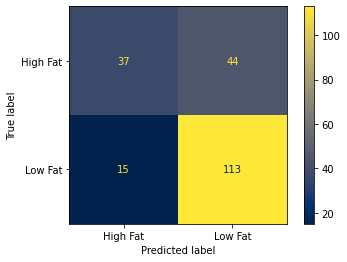

In [20]:
#let's see how our model scores on our test set - better than Dummy classifier
print(str(round(SVC_random.score(X_test,y_test),4)) + ' SVC model score on test')
print(SVC_random.best_params_)

#let look at different scoring metrics with lower fat as our positive by way of a classification report. From module 7 

print(classification_report(y_test, SVC_random.predict(X_test),
        target_names=["High Fat", "Low Fat"]))


#how does our confusion matrix look?
plot_confusion_matrix(SVC_random, X_test, y_test, display_labels=["High Fat", "Low Fat"], values_format="d", cmap="cividis")

In [54]:
from sklearn.linear_model import LogisticRegression

#let's build one more model - Logistic Regression, Module 8



#create pipeline for new model, default parameters
pipe_LR = make_pipeline(preprocessor,LogisticRegression(n_jobs=-1))

param_grid = {
    "logisticregression__C":scipy.stats.uniform(0, 100),
'logisticregression__tol':scipy.stats.uniform(0, 100)}


#lets see what this model scores using default parameters
pipe_LR.fit(X_train, y_train)
print(str(round(pipe_LR.score(X_train, y_train),4)) + ' LR default params score')

#search over params per above, see if there is an improvement vs default
LR_random = RandomizedSearchCV(pipe_LR, param_grid, cv=10, verbose=0, n_jobs=-1, n_iter=50)
LR_random.fit(X_train, y_train)
print(str(round(LR_random.score(X_train,y_train),4)) + ' Best model using randomized hyperparameter tuning')

0.8055 LR default params score
0.8055 Best model using randomized hyperparameter tuning


{'logisticregression__C': 17.386005867695797,
 'logisticregression__tol': 7.866549005777557}

###Logistic Regression Model discussion

testset

## References

* https://altair-viz.github.io/gallery/layered_histogram.html
* https://altair-viz.github.io/gallery/stacked_bar_chart.html
* https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
* https://stackoverflow.com/questions/70060244/after-hyperparameter-tuning-accuracy-remains-the-same